In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from reservoirpy.nodes import Reservoir, Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report as creport
from imblearn.over_sampling import SMOTE 
from sklearn.model_selection import TimeSeriesSplit
import shap
from xgboost import XGBClassifier
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
def one_hot_encode(df, drop_original=True, prefix_sep="_"):

    non_numeric_cols = df.select_dtypes(exclude=["number"]).columns.tolist()
    
    if not non_numeric_cols:
        return df.copy()

    df_encoded = pd.get_dummies(df, columns=non_numeric_cols, prefix_sep=prefix_sep)

    return df_encoded

def find_high_corr_features(df, target_col, threshold=0.9):

    # Drop non-numeric columns
    numeric_df = df.select_dtypes(include='number')

    if target_col not in numeric_df.columns:
        raise ValueError(f"Target column '{target_col}' is not numeric or missing from the DataFrame.")

    # Compute correlations
    corrs = numeric_df.corr()[target_col].drop(target_col)

    # Find strong correlations
    high_corr_features = corrs[abs(corrs) > threshold].sort_values(ascending=False)

    if high_corr_features.empty:
        print("✅ No features are correlated above the threshold.")
    else:
        print("⚠️ High correlation detected:")
        print(high_corr_features)

    return list(high_corr_features.index)

def split_sequentially(df_x, df_y, train = 0.8):
    n_samples = len(df_x)
    split_idx = int(n_samples * train)

    X_train = df_x.iloc[:split_idx]
    X_test = df_x.iloc[split_idx:]

    y_train = df_y.iloc[:split_idx]
    y_test = df_y.iloc[split_idx:]
    
    return X_train, X_test, y_train, y_test

### 12 Hours

In [9]:
df = pd.read_csv('data/clean_df.csv')
df['date'] = pd.to_datetime(df['date'])
df['time'] = (df['date'] - df['date'].min()).dt.total_seconds() / 3600

In [4]:
find_high_corr_features(df, 'ext_gust_window_72')

✅ No features are correlated above the threshold.


[]

In [10]:
df.drop(['high_wind_event','valid_time','date'], axis=1, inplace=True)
df.drop(['ext_gust_window_48','ext_gust_window_72','ext_gust_window_168', 'ext_gust_window_720','ext_gust_window_24'], axis=1, inplace=True)
df = one_hot_encode(df)
df_y = df['ext_gust_window_12']
df_x = df.drop(['ext_gust_window_12'], axis=1)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.20, random_state=42)
#X_train, X_test, y_train, y_test = split_sequentially(df_x, df_y)

scaler_X = StandardScaler()
X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)

In [12]:
# base

xgb_model = XGBClassifier(n_estimators=2, max_depth=2, learning_rate=1, objective='binary:logistic')
xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)
print(creport(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      5245
           1       0.65      0.15      0.24       103

    accuracy                           0.98      5348
   macro avg       0.82      0.57      0.61      5348
weighted avg       0.98      0.98      0.98      5348



In [13]:
reservoir = Reservoir(units=5000, sr=0.8)  
X_train_reservoir = reservoir.run(X_train, reset=True)  

classifier = LogisticRegression()
classifier.fit(X_train_reservoir, y_train)
 
X_test_reservoir = reservoir.run(X_test, reset=True)
y_pred_probs = classifier.predict_proba(X_test_reservoir)[:, 1] 
y_pred = (y_pred_probs > 0.2).astype(int) 

print(creport(y_test, y_pred))

Running Reservoir-1: 100%|██████████████████████████████████████████████████████████| 21390/21390 [00:42<00:00, 505.83it/s]
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
Running Reservoir-1: 100%|████████████████████████████████████████████████████████████| 5348/5348 [00:10<00:00, 504.41it/s]

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5245
           1       0.77      0.80      0.78       103

    accuracy                           0.99      5348
   macro avg       0.88      0.90      0.89      5348
weighted avg       0.99      0.99      0.99      5348



In [14]:
#### Sanity Check

In [15]:
from sklearn.datasets import make_hastie_10_2
x, y = make_hastie_10_2(n_samples=24000, random_state=42)

In [16]:
y = [0 if i == -1 else 1 for i in y]

In [17]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

scaler_X = StandardScaler()
X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)

In [18]:
reservoir = Reservoir(units=5000, sr=0.8)  
X_train_reservoir = reservoir.run(X_train, reset=True)  

classifier = LogisticRegression()
classifier.fit(X_train_reservoir, y_train)

reservoir = Reservoir(units=5000, sr=0.8)  
X_test_reservoir = reservoir.run(X_test, reset=True)
y_pred_probs = classifier.predict_proba(X_test_reservoir)[:, 1] 
y_pred = (y_pred_probs > 0.5).astype(int) 


print(creport(y_test, y_pred))

Running Reservoir-2: 100%|██████████████████████████████████████████████████████████| 19200/19200 [00:31<00:00, 604.22it/s]
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
Running Reservoir-3: 100%|████████████████████████████████████████████████████████████| 4800/4800 [00:08<00:00, 583.64it/s]

              precision    recall  f1-score   support

           0       0.49      0.47      0.48      2439
           1       0.48      0.51      0.49      2361

    accuracy                           0.49      4800
   macro avg       0.49      0.49      0.49      4800
weighted avg       0.49      0.49      0.49      4800



In [19]:
#### 24

In [86]:
df = pd.read_csv('data/clean_df.csv')
df['date'] = pd.to_datetime(df['date'])
df['time'] = (df['date'] - df['date'].min()).dt.total_seconds() / 3600

df.drop(['high_wind_event','valid_time','date'], axis=1, inplace=True)
df.drop(['ext_gust_window_12','ext_gust_window_48','ext_gust_window_168', 'ext_gust_window_720', 'ext_gust_window_48'], axis=1, inplace=True)
df = one_hot_encode(df)
df_y = df['ext_gust_window_24']
df_x = df.drop(['ext_gust_window_24'], axis=1)

In [87]:
X_train, X_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.20, random_state=42)

scaler_X = StandardScaler()
X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)

In [88]:
reservoir = Reservoir(units=5000, sr=0.8)  
X_train_reservoir = reservoir.run(X_train, reset=True)  

classifier = LogisticRegression()
classifier.fit(X_train_reservoir, y_train)

X_test_reservoir = reservoir.run(X_test, reset=True)
y_pred_probs = classifier.predict_proba(X_test_reservoir)[:, 1] 
y_pred = (y_pred_probs > 0.5).astype(int) 

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(creport(y_test, y_pred))

Running Reservoir-13: 100%|█████████████████████████████████████████████████████████| 21390/21390 [00:42<00:00, 500.75it/s]
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
Running Reservoir-13: 100%|███████████████████████████████████████████████████████████| 5348/5348 [00:10<00:00, 494.82it/s]

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5226
           1       0.89      0.89      0.89       122

    accuracy                           0.99      5348
   macro avg       0.94      0.95      0.94      5348
weighted avg       0.99      0.99      0.99      5348



In [20]:
### 48 Hours

In [21]:
df = pd.read_csv('data/clean_df.csv')
df['date'] = pd.to_datetime(df['date'])
df['time'] = (df['date'] - df['date'].min()).dt.total_seconds() / 3600

df.drop(['high_wind_event','valid_time','date'], axis=1, inplace=True)
df.drop(['ext_gust_window_12','ext_gust_window_72','ext_gust_window_168', 'ext_gust_window_720','ext_gust_window_24'], axis=1, inplace=True)
df = one_hot_encode(df)
df_y = df['ext_gust_window_48']
df_x = df.drop(['ext_gust_window_48'], axis=1)

In [22]:
X_train, X_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.20, random_state=42)

scaler_X = StandardScaler()
X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)

In [23]:
reservoir = Reservoir(units=5000, sr=0.8)  
X_train_reservoir = reservoir.run(X_train, reset=True)  

classifier = LogisticRegression()
classifier.fit(X_train_reservoir, y_train)

X_test_reservoir = reservoir.run(X_test, reset=True)
y_pred_probs = classifier.predict_proba(X_test_reservoir)[:, 1] 
y_pred = (y_pred_probs > 0.5).astype(int) 

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(creport(y_test, y_pred))

Running Reservoir-4: 100%|██████████████████████████████████████████████████████████| 21390/21390 [00:42<00:00, 504.78it/s]
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
Running Reservoir-4: 100%|████████████████████████████████████████████████████████████| 5348/5348 [00:10<00:00, 508.41it/s]

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5223
           1       0.86      0.86      0.86       125

    accuracy                           0.99      5348
   macro avg       0.93      0.93      0.93      5348
weighted avg       0.99      0.99      0.99      5348



In [24]:
### 72 Hours

In [131]:
df = pd.read_csv('data/clean_df.csv')
df['date'] = pd.to_datetime(df['date'])
df['time'] = (df['date'] - df['date'].min()).dt.total_seconds() / 3600

df.drop(['high_wind_event','valid_time','date'], axis=1, inplace=True)
df.drop(['ext_gust_window_12','ext_gust_window_48','ext_gust_window_168', 'ext_gust_window_720', 'ext_gust_window_24'], axis=1, inplace=True)
df = one_hot_encode(df)
df_y = df['ext_gust_window_72']
df_x = df.drop(['ext_gust_window_72'], axis=1)

In [132]:
X_train, X_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.20, random_state=42)

scaler_X = StandardScaler()
X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)

In [133]:
reservoir = Reservoir(units=5000, sr=0.8)  
X_train_reservoir = reservoir.run(X_train, reset=True)  

classifier = LogisticRegression()
classifier.fit(X_train_reservoir, y_train)

X_test_reservoir = reservoir.run(X_test, reset=True)
y_pred_probs = classifier.predict_proba(X_test_reservoir)[:, 1] 
y_pred = (y_pred_probs > 0.5).astype(int) 

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(creport(y_test, y_pred))

Running Reservoir-14: 100%|█████████████████████████████████████████████████████████| 21390/21390 [00:41<00:00, 513.74it/s]
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
Running Reservoir-14: 100%|███████████████████████████████████████████████████████████| 5348/5348 [00:10<00:00, 516.93it/s]


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5165
           1       0.92      0.86      0.89       183

    accuracy                           0.99      5348
   macro avg       0.96      0.93      0.94      5348
weighted avg       0.99      0.99      0.99      5348



In [142]:
X_test = scaler_X.inverse_transform(X_test)

X_test_df = pd.DataFrame(X_test, columns=df_x.columns)

# Add y_true and y_pred
X_test_df["y_true"] = y_test.reset_index(drop=True)
X_test_df["y_pred"] = pd.Series(y_pred).reset_index(drop=True)

# Optional: Add correctness flag
X_test_df["correct"] = (X_test_df["y_true"] == X_test_df["y_pred"]).astype(int)

In [118]:
positives_only = X_test_df[X_test_df["y_true"] == 1]

# Split into correct vs. incorrect predictions
true_positives = positives_only[positives_only["y_pred"] == 1]
false_negatives = positives_only[positives_only["y_pred"] == 0]

In [119]:
def plot_tp_fn_kde(positives_df, feature, bw_adjust=1.0):
    """
    Plot KDE (line) plots of a feature for true positives vs false negatives.
    Assumes DataFrame is filtered to y_true == 1.
    
    Parameters:
    - positives_df: DataFrame where y_true == 1
    - feature: str, the column name of the feature to plot
    - bw_adjust: float, bandwidth adjustment for KDE smoothness
    """

    sns.set(style="whitegrid")

    # Label prediction outcomes
    outcome_map = {1: "True Positive", 0: "False Negative"}
    plot_df = positives_df.copy()
    plot_df["Prediction"] = plot_df["y_pred"].map(outcome_map)

    plt.figure(figsize=(8, 5))
    sns.kdeplot(data=plot_df, x=feature, hue="Prediction", bw_adjust=bw_adjust,
                common_norm=False, fill=False, palette=["green", "red"])
    plt.title(f"Smoothed Distribution of '{feature}'\nTrue Positives vs False Negatives")
    plt.xlabel(feature)
    plt.ylabel("Density")
    #plt.legend()
    plt.tight_layout()
    plt.show()


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


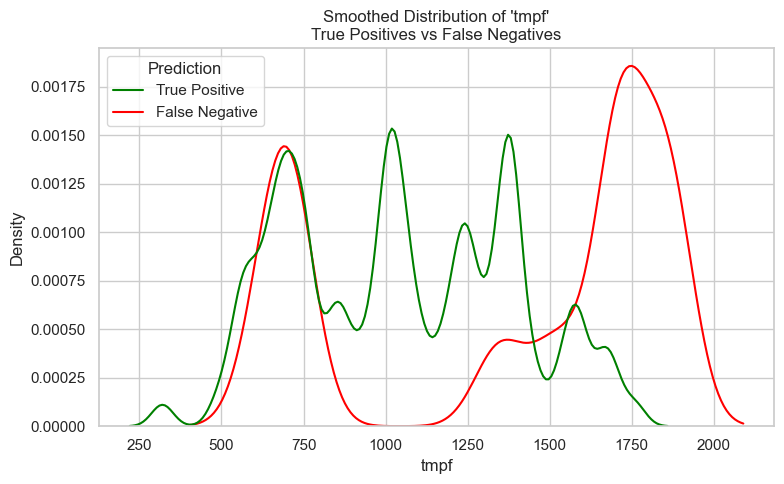

In [120]:
plot_tp_fn_kde(positives_only, 'tmpf', 0.25)

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


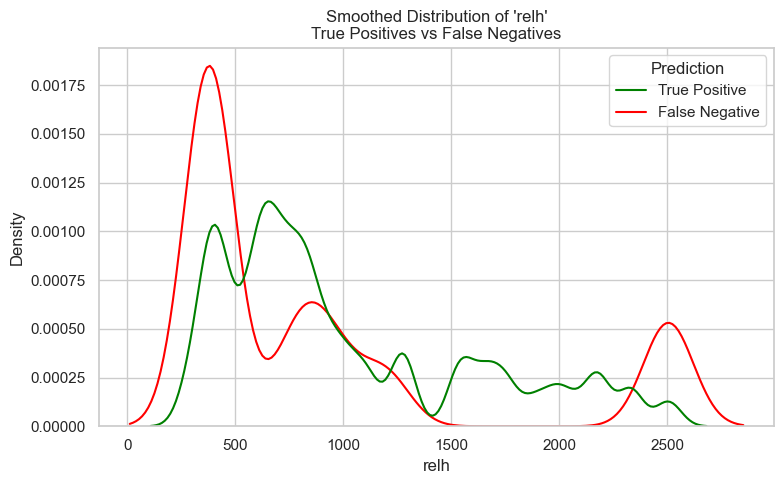

In [121]:
plot_tp_fn_kde(positives_only, 'relh', 0.25)
    

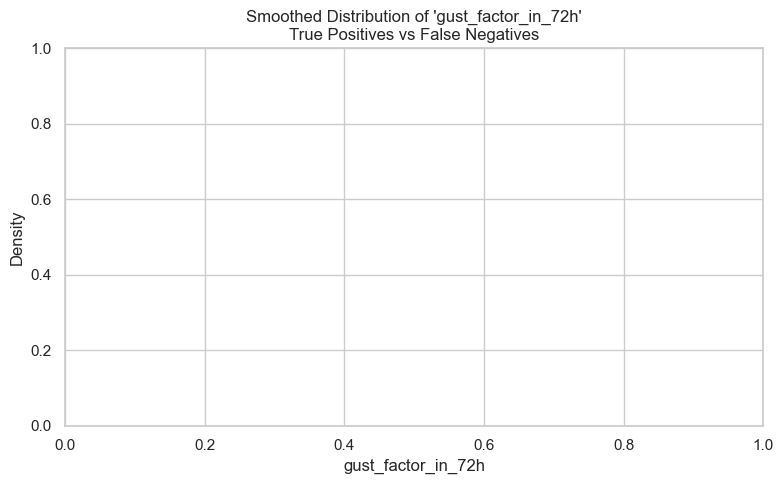

In [122]:
plot_tp_fn_kde(positives_only, 'gust_factor_in_72h', 0.25)

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


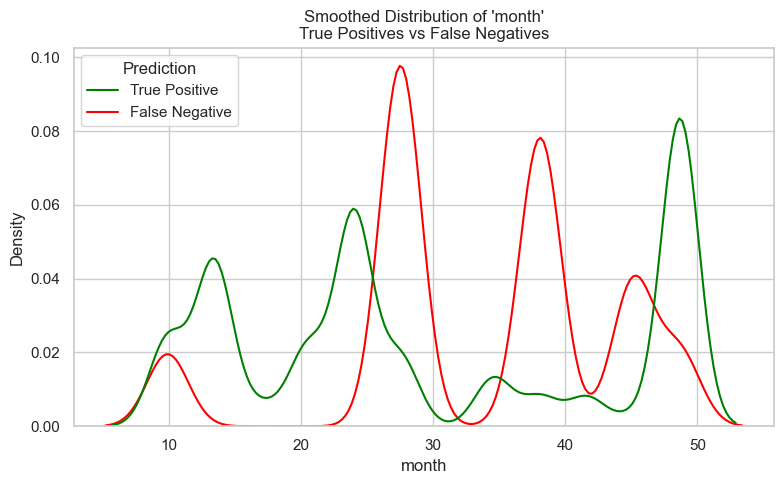

In [123]:
plot_tp_fn_kde(positives_only, 'month', 0.25)

In [28]:
### 168 Hours

In [29]:
df = pd.read_csv('data/clean_df.csv')
df['date'] = pd.to_datetime(df['date'])
df['time'] = (df['date'] - df['date'].min()).dt.total_seconds() / 3600

df.drop(['high_wind_event','valid_time','date'], axis=1, inplace=True)
df.drop(['ext_gust_window_12','ext_gust_window_48','ext_gust_window_72', 'ext_gust_window_720'], axis=1, inplace=True)
df = one_hot_encode(df)
df_y = df['ext_gust_window_168']
df_x = df.drop(['ext_gust_window_168'], axis=1)

In [30]:
X_train, X_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.20, random_state=42)

scaler_X = StandardScaler()
X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)

In [31]:
reservoir = Reservoir(units=5000, sr=0.8)  
X_train_reservoir = reservoir.run(X_train, reset=True)  

classifier = LogisticRegression()
classifier.fit(X_train_reservoir, y_train)

reservoir = Reservoir(units=5000, sr=0.8)  
X_test_reservoir = reservoir.run(X_test, reset=True)
y_pred_probs = classifier.predict_proba(X_test_reservoir)[:, 1] 
y_pred = (y_pred_probs > 0.5).astype(int) 

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(creport(y_test, y_pred))

Running Reservoir-6: 100%|██████████████████████████████████████████████████████████| 21390/21390 [00:41<00:00, 512.23it/s]
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
Running Reservoir-7: 100%|████████████████████████████████████████████████████████████| 5348/5348 [00:10<00:00, 506.91it/s]

              precision    recall  f1-score   support

           0       0.93      0.66      0.77      4895
           1       0.11      0.47      0.18       453

    accuracy                           0.64      5348
   macro avg       0.52      0.56      0.48      5348
weighted avg       0.86      0.64      0.72      5348



In [32]:
### 1 month

In [40]:
df = pd.read_csv('data/clean_df.csv')
df['date'] = pd.to_datetime(df['date'])
df['time'] = (df['date'] - df['date'].min()).dt.total_seconds() / 3600

df.drop(['high_wind_event','valid_time','date'], axis=1, inplace=True)
df.drop(['ext_gust_window_12','ext_gust_window_48','ext_gust_window_72', 'ext_gust_window_168'], axis=1, inplace=True)
df = one_hot_encode(df)
df_y = df['ext_gust_window_720']
df_x = df.drop(['ext_gust_window_720'], axis=1)

In [43]:
X_train, X_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.20, random_state=42)

scaler_X = StandardScaler()
X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)

In [35]:
reservoir = Reservoir(units=5000, sr=0.8)  
X_train_reservoir = reservoir.run(X_train, reset=True)  

classifier = LogisticRegression()
classifier.fit(X_train_reservoir, y_train)

reservoir = Reservoir(units=5000, sr=0.8)  
X_test_reservoir = reservoir.run(X_test, reset=True)
y_pred_probs = classifier.predict_proba(X_test_reservoir)[:, 1] 
y_pred = (y_pred_probs > 0.5).astype(int) 

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(creport(y_test, y_pred))

Running Reservoir-8: 100%|██████████████████████████████████████████████████████████| 21390/21390 [00:41<00:00, 511.07it/s]
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
Running Reservoir-9: 100%|████████████████████████████████████████████████████████████| 5348/5348 [00:10<00:00, 502.76it/s]


              precision    recall  f1-score   support

           0       0.86      0.67      0.76      4622
           1       0.14      0.33      0.19       726

    accuracy                           0.63      5348
   macro avg       0.50      0.50      0.47      5348
weighted avg       0.77      0.63      0.68      5348



In [44]:
y_pred = np.random.choice([0, 1], size=len(y_test))
print(creport(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.51      0.64      4622
           1       0.14      0.51      0.22       726

    accuracy                           0.51      5348
   macro avg       0.50      0.51      0.43      5348
weighted avg       0.77      0.51      0.58      5348



find_high_corr_features(df, 'ext_gust_window_168')

# let's try with SMOTE

In [36]:
X_train, X_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.15, random_state=42)

In [37]:
oversample = SMOTE(random_state=1234, sampling_strategy=0.99)

X_train, y_train = oversample.fit_resample(X_train, y_train) 

In [38]:
scaler_X = StandardScaler()

X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)

reservoir = Reservoir(units=5000, sr=0.8)  
X_train_reservoir = reservoir.run(X_train)  

classifier = LogisticRegression()
classifier.fit(X_train_reservoir, y_train)

X_test_reservoir = reservoir.run(X_test)
y_pred_probs = classifier.predict_proba(X_test_reservoir)[:, 1] 
y_pred = (y_pred_probs > 0.5).astype(int) 

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(creport(y_test, y_pred))

Running Reservoir-10: 100%|█████████████████████████████████████████████████████████| 39240/39240 [01:16<00:00, 512.24it/s]
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
Running Reservoir-10: 100%|███████████████████████████████████████████████████████████| 4011/4011 [00:07<00:00, 502.26it/s]


              precision    recall  f1-score   support

           0       1.00      0.99      1.00      3452
           1       0.96      0.98      0.97       559

    accuracy                           0.99      4011
   macro avg       0.98      0.99      0.98      4011
weighted avg       0.99      0.99      0.99      4011

